# Master Thesis - Particle Swarm Optimization with constraints - Implementation (Numerical Scheme)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The equations of motion for particle swarm optimization are obtained by adding the interaction, friction, exploration, and constraint terms and this can be written in continuous time formulation as
\begin{equation}
\begin{aligned}
    dX^i(t) &= V^i(t)dt \\
    dV^i(t) &= -\lambda(X^i(t)-\overline{X}(t))dt - \gamma V_i(t)dt+\sigma(t)dB^i(t) +dR(t),
\end{aligned}
\end{equation}
where $dR(t)$ is defined as 
\begin{equation}
    dR(t) = -2\braket{n(X^i(t)),V^i(t)}n(X^i(t))I_{\partial G}(X(t)),
\end{equation}
 $\lambda$ and $\gamma$ are hyper-parameters which will be tested in a range and evaluated using a success rate 
\begin{equation}
    ||X_{min}-X^*|| < 0.2
\end{equation}
Where $X^*$ is the collapsed ensamble value of the positions. Collapsed means that all particles have converged to the same position, which is inevitable if the global minimum has been found due to the interaction term.

To use these SDEs for numerical simulations they have to be rewritten in discrete time formulation. This is done by way of Euler-Maruyama scheme shown in equation to obtain the expression for the position and velocity seen in equation

\begin{equation}
\begin{aligned}
    X_{k+1}^i &= X_k^i + V_k^ih, \\
    V_{k+1}^i &= V_k^i -\lambda(X^i_k-\overline{X}_k)h - \gamma V^i_kh+\sigma_k\sqrt{h}\xi_{k+1}^i+dR_k,
\end{aligned}
\end{equation}
note that $\sigma_k = \sigma(t_k)$, and


In [21]:
T = 10 # Total time
h = 0.01 # time step
N = int(T/h) # number of time steps, 100
N_particles = 100
X = np.zeros((N_particles,2))

In [13]:
def sigma_function(time):
    t_0 = 5.0
    if time < t_0:
        return 15
    else:
        return 10**(-5)

PSO is driven by SDE that contains four terms: an interaction term that looks like 
\begin{equation}
    -\int_0^t\lambda(X^i(s)-\overline{X}(s))ds,
\end{equation} 
where $X^i(s)$ is the position of a particle, i, at time, t and $\overline{X}(s)$ is a weighted average of all particles at a time t. The weighted average is defined as
\begin{equation}
    \overline{X}(t) = \sum_{j=1}^N \frac{X^j(t)e^{-\alpha U(X^j(t))}}{\sum_{l=1}^Ne^{-\alpha U(X^l(t))}} = \left[\frac{e^{-\alpha U(X^j(t))}}{\sum_{l=1}^Ne^{-\alpha U(X^l(t))}} \equiv w^j\right] = \sum_{j=1}^N X^j(t)w^j,
\end{equation}

In [4]:
def weighted_average(X, alpha, objective_function):
    values = -alpha * objective_function(X)
    clipped_values = np.clip(values, -700, 700)  # Prevent overflow
    exp_values = np.exp(clipped_values)
    total_weight = np.sum(exp_values)
    w = exp_values / total_weight
    w = w.reshape(-1, 1)
    return np.sum(w * X, axis=0)

In [5]:
def best_particle(X, objective_function):
    values = objective_function(X)
    best_particle = X[np.argmin(values)]
    return best_particle

$dR_k$ is the reflective term in discrete time formulation.

IF $\hat{X}^i_{k+1} \in G^C$:
\begin{equation}
\begin{aligned}
X^i_{\tau,k+1} &= X^i_k+\tau V^i_k \in \partial G, [\tau \in (0,h)] \\
\hat{V}^i_k &= V^i_k -2\braket{ n(X^i_{\tau,k+1}),V^i_k} n(X^i_{\tau,k+1}) \\
X^i_{k+1} &= X^i_{\tau,k+1}+(h-\tau)\hat{V}^i_k
\end{aligned}
\end{equation} 

ELSE:
\begin{equation}
\begin{aligned}
X^i_{k+1} &= \hat{X}^i_{k+1} \\
\hat{V}^i_k &= V^i_k
\end{aligned}
\end{equation}

For this function i need to return $-2\braket{ n(X^i_{\tau,k+1}),V^i_k} n(X^i_{\tau,k+1})$, if $X_{new}$ went into $G^C$, and 0 otherwise

In [6]:
def Reflection_spherical(X_old, V, radius,reflection_counter):
    global h
    N_particles = X_old.shape[0]
    X_new = X_old + h * V
    
    # Calculate norms for all particles
    norms = np.linalg.norm(X_new, axis=1)
    
    # Identify particles that need reflection
    reflect_mask = norms > radius
    original_counter = reflection_counter[0]
    reflection_counter[0] = original_counter + np.sum(reflect_mask)
    
    if np.any(reflect_mask):
        a = X_old[reflect_mask]
        b = V[reflect_mask]
        
        # Vectorized calculations
        p = 2 * np.sum(a * b, axis=1) / np.sum(b**2, axis=1)
        q = (np.sum(a**2, axis=1) - radius**2) / np.sum(b**2, axis=1)
        # Add epsilon and use np.maximum to avoid negative values under sqrt
        tau = -p/2 + np.sqrt(p**2/4 - q)
        NaN_mask = np.isnan(tau)
        num_nan = np.sum(NaN_mask)
        a[NaN_mask] = np.random.uniform(-512, 512, (num_nan, 2))
        b[NaN_mask] = np.random.uniform(-1, 1, (num_nan, 2))
        
        X_tau = a + tau[:, np.newaxis] * b
        
        # Calculate outward normals
        outward_normal = X_tau / np.linalg.norm(X_tau, axis=1)[:, np.newaxis]
         #the outward normal is calculated as the normalized position vector of the intersection point X_tau.
        #This works because for a circular (or spherical) boundary centered at the origin, 
        # the outward normal at any point on the boundary is simply the unit vector pointing from the origin to that point.
        
        # Calculate reflected velocities
        V_hat = b - 2 * np.sum(b * outward_normal, axis=1)[:, np.newaxis] * outward_normal
        
        # Update positions for reflected particles
        X_new[reflect_mask] = X_tau + (h - tau[:, np.newaxis]) * V_hat
        V[reflect_mask] = V_hat
    
    return X_new, V


In [7]:
def reflection_square(X_old, V, square_length, reflection_counter):
    global h
    X_new = X_old + h * V
    
    # Create masks for boundary crossings
    reflect_x = (np.abs(X_new[:, 0]) > square_length)
    reflect_y = (np.abs(X_new[:, 1]) > square_length)
    
    # Update reflection counter
    original_counter = reflection_counter[0]
    reflection_counter[0] = original_counter + np.sum(reflect_x) + np.sum(reflect_y)
    
    # Process X-axis reflections
    if np.any(reflect_x):
        a_x = X_old[reflect_x]
        b_x = V[reflect_x]
        
        # Calculate intersection times for X-boundary
        Vx = b_x[:, 0]
        boundary_x = np.where(Vx > 0, square_length, -square_length)
        tau_x = (boundary_x - a_x[:, 0]) / Vx
        
        # Handle Vx=0 cases (particles already outside boundary)
        tau_x = np.where(Vx == 0, h, tau_x)
        
        # Move to boundary and reflect velocity
        X_tau_x = a_x.copy()
        X_tau_x[:, 0] = boundary_x
        V_hat_x = b_x.copy()
        V_hat_x[:, 0] *= -1
        
        # Update positions and velocities
        X_new[reflect_x] = X_tau_x + (h - tau_x[:, None]) * V_hat_x
        V[reflect_x] = V_hat_x
    
    # Process Y-axis reflections
    if np.any(reflect_y):
        a_y = X_old[reflect_y]
        b_y = V[reflect_y]
        
        # Calculate intersection times for Y-boundary
        Vy = b_y[:, 1]
        boundary_y = np.where(Vy > 0, square_length, -square_length)
        tau_y = (boundary_y - a_y[:, 1]) / Vy
        
        # Handle Vy=0 cases
        tau_y = np.where(Vy == 0, h, tau_y)
        
        # Move to boundary and reflect velocity
        X_tau_y = a_y.copy()
        X_tau_y[:, 1] = boundary_y
        V_hat_y = b_y.copy()
        V_hat_y[:, 1] *= -1
        
        # Update positions and velocities
        X_new[reflect_y] = X_tau_y + (h - tau_y[:, None]) * V_hat_y
        V[reflect_y] = V_hat_y
    
    return X_new, V


and the iterative update of the discrete velocity is
\begin{equation}
    V^i_{k+1} = \hat{V}^i_k -\lambda(X^i_{k+1}-\overline{X}_{k+1})h - \gamma \hat{V}^i_k h + \sigma_k\xi^i_{k+1}\sqrt{h}.
\end{equation}

In [8]:
def PSO(X_old, V_old,objective_function, Lambda, gamma, sigma,radius, reflection_counter, square = True):
    # X: particle positions
    # weighted_average_X: weighted average of particle positions
    # V: particle velocities
    # Lambda: interaction coefficient
    # gamma: inertia coefficient
    # sigma: exploration coefficient
    # returns updated X, weighted_average_X, V
    N_particles = X_old.shape[0]

    global h
    if square == True:
        X_hat, V_hat = reflection_square(X_old,V_old,radius,reflection_counter)
    else:
        X_hat, V_hat = Reflection_spherical(X_old,V_old,radius,reflection_counter)
    
    X_new = X_hat
    best_particle_X = best_particle(X_hat,objective_function)
    #weighted_average_X = weighted_average(X_new,alpha,objective_function)
    V_new = V_hat - Lambda*(X_new-best_particle_X)*h-gamma*V_hat*h+sigma*np.sqrt(h)*np.random.randn(N_particles,1)
    
    return X_new, V_new

In [9]:
def results_to_table(results, lambda_values, gamma_values):
    """
    Generate a LaTeX table for success rates based on combinations of lambda and gamma.

    Args:
        results (list of lists): Success rates for different lambda and gamma combinations.
        lambda_values (list): Values of lambda (used as rows in the table).
        gamma_values (list): Values of gamma (used as columns in the table).
    """
    print(r"\begin{table}[]")
    print(r"\begin{tabular}{l|" + "l" * len(gamma_values) + "}")
    print(r"\backslashbox{$\lambda$}{$\gamma$} & " + " & ".join([str(val) for val in gamma_values]) + r" \\ \hline")
    
    for i, row in enumerate(results):
        lambda_value = f"$\lambda = {lambda_values[i]}$"
        formatted_row = [f"{value:.1f}\\%" for value in row]  # Convert each value to percentage
        print(f"{lambda_value} & " + " & ".join(formatted_row) + r" \\")
    
    print(r"\end{tabular}")
    print(r"\end{table}")


# Benchmark functions to test method on:
- Eggholder function, global minima located at ${\displaystyle f(512,404.2319)=-959.6407}$
- Cross-In-Tray function 4 global minima located at ${\displaystyle {\text{Min}}={\begin{cases}f\left(1.34941,-1.34941\right)&=-2.06261\\f\left(1.34941,1.34941\right)&=-2.06261\\f\left(-1.34941,1.34941\right)&=-2.06261\\f\left(-1.34941,-1.34941\right)&=-2.06261\\\end{cases}}}$

For Eggholder case the radius used in reflection_spherical must be larger than the distance to where the global minima is located, which is $\approx 653$, meaning a radius of 700 will work fine.

For cross-in-tray function the minimas are located at a distance of $\approx 1.91$ from origin which means a radius of 2 will be employed. 

In [10]:
def egg_holder(X):
    x = X[:,0]
    y = X[:,1]
    return -(y+47)*np.sin(np.sqrt(np.abs(x/2+(y+47))))-x*np.sin(np.sqrt(np.abs(x-(y+47))))

In [11]:
def cross_in_tray(X):
    x = X[:,0]
    y = X[:,1]
    return -0.0001*(np.abs(np.sin(x)*np.sin(y)*np.exp(np.abs(100-np.sqrt(x**2+y**2)/np.pi)))+1)**0.1

In [ ]:
#Grid search for optimal parameters
alpha = 0.5
Lambda = 5
gamma = 1

radius = 730

objective_function = egg_holder

particle_positions_X = np.random.uniform(-512,512,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
best_min = np.inf
time = 0
# Create a grid for the contour plot
x = np.linspace(-radius, radius, 1000)
y = np.linspace(-radius, radius, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)

# Plotting

for lambda_ in np.linspace(1,10,10):
    for gamma_ in np.linspace(0.1,1,10):
        Lambda = lambda_
        gamma = gamma_
        time = 0
        reflection_counter = [0]
        particle_positions_X = np.random.uniform(-512,512,(N_particles,2))
        particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
        while time<T:
            sigma = sigma_function(time)
            particle_positions_X, particle_velocities_V = PSO(particle_positions_X, particle_velocities_V,alpha,objective_function,Lambda,gamma,sigma,radius,reflection_counter)
            time += h
        if np.min(objective_function(particle_positions_X)) < best_min:
            plt.figure(figsize=(10, 8))
            plt.contourf(X, Y, Z, levels=50, cmap='viridis', alpha=0.7)
            plt.colorbar(label='Egg Holder Function Value')
            plt.xlim(-512, 512)
            plt.ylim(-512, 512)
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.title(f'PSO Results (α={alpha}, λ={Lambda:.2f}, γ={gamma:.2f})')
            best_min = np.min(objective_function(particle_positions_X))
            print("alpha: ",alpha,"Lambda: ",Lambda,"gamma: ",gamma,"objective: ",np.min(objective_function(particle_positions_X)))
            plt.plot(particle_positions_X[:,0],particle_positions_X[:,1],'ro',markersize = 1)
            plt.show()
            print("Reflections: ",reflection_counter)
            
            '''plt.figure(figsize=(10, 8))
            
            # Create circular mask
            mask = X**2 + Y**2 <= radius**2
            Z_masked = np.ma.masked_where(~mask, Z)
            
            # Plot masked contour
            
            plt.contourf(X, Y, Z_masked,levels=50, cmap='viridis', alpha=0.7, shading='auto')
            plt.colorbar(label='Egg Holder Function Value')
            
            # Add circle boundary
            circle = plt.Circle((0, 0), radius, fill=False, color='red', linewidth=2)
            plt.gca().add_artist(circle)
            
            plt.xlim(-radius, radius)
            plt.ylim(-radius, radius)
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.title(f'PSO Results (α={alpha}, λ={Lambda:.2f}, γ={gamma:.2f})')
            best_min = np.min(objective_function(particle_positions_X))
            print("alpha: ",alpha,"Lambda: ",Lambda,"gamma: ",gamma,"objective: ",np.min(objective_function(particle_positions_X)))
            
            # Plot particles
            plt.plot(particle_positions_X[:,0], particle_positions_X[:,1], 'ro', markersize=1)
            
            plt.axis('equal')  # Ensure circular shape
            plt.show()
            print("Reflections: ",reflection_counter)'''



In [ ]:
#Grid search for optimal parameters
Lambda = 10
gamma = 1.75
N_particles = 1000
radius = 512
objective_function = egg_holder

particle_positions_X = np.random.uniform(-512,512,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
time = 0
# Create a grid for the contour plot
x = np.linspace(-512, 512, 1000)
y = np.linspace(-512, 512, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)

best_min = np.min(objective_function(particle_positions_X))
print("N_particles: ",N_particles,"Lambda: ",Lambda,"gamma: ",gamma,"objective: ",np.min(objective_function(particle_positions_X)))
min_x, min_y = [512,404.2319]

reflection_counter = [0]
plot_list = [0,50,100,200,300,400,499]
while time<T:
    iteration = int(time/h)
    #print(iteration)
    if iteration in plot_list:
        plt.figure(figsize=(10, 8))
        # Plotting

        plt.contourf(X, Y, Z, levels=50, cmap='viridis', alpha=0.7)
        plt.colorbar(label='Egg Holder Function Value')
        plt.xlim(-512, 512)
        plt.ylim(-512, 512)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'PSO Results (N_p={N_particles}, λ={Lambda:.2f}, γ={gamma:.2f}), Iteration: {iteration}')
        plt.plot(particle_positions_X[:,0], particle_positions_X[:,1], 'ro', markersize=1, alpha=0.5)
        best_min_x, best_min_y = best_particle(particle_positions_X,objective_function)
        plt.scatter(best_min_x, best_min_y, color='black', s=100, zorder=5, marker='x')
        plt.scatter(min_x, min_y, color='orange', s=100, zorder=5, marker='*')
    sigma = sigma_function(time)
    particle_positions_X, particle_velocities_V = PSO(particle_positions_X, particle_velocities_V,objective_function,Lambda,gamma,sigma,radius,reflection_counter, square = True)
    time += h

min_index = np.argmin(objective_function(particle_positions_X))

print(min_x, min_y, objective_function(particle_positions_X)[min_index])
print("Reflections: ",reflection_counter[0]) 



N_particles:  1000 Lambda:  10 gamma:  1.75 objective:  -880.0821149513613


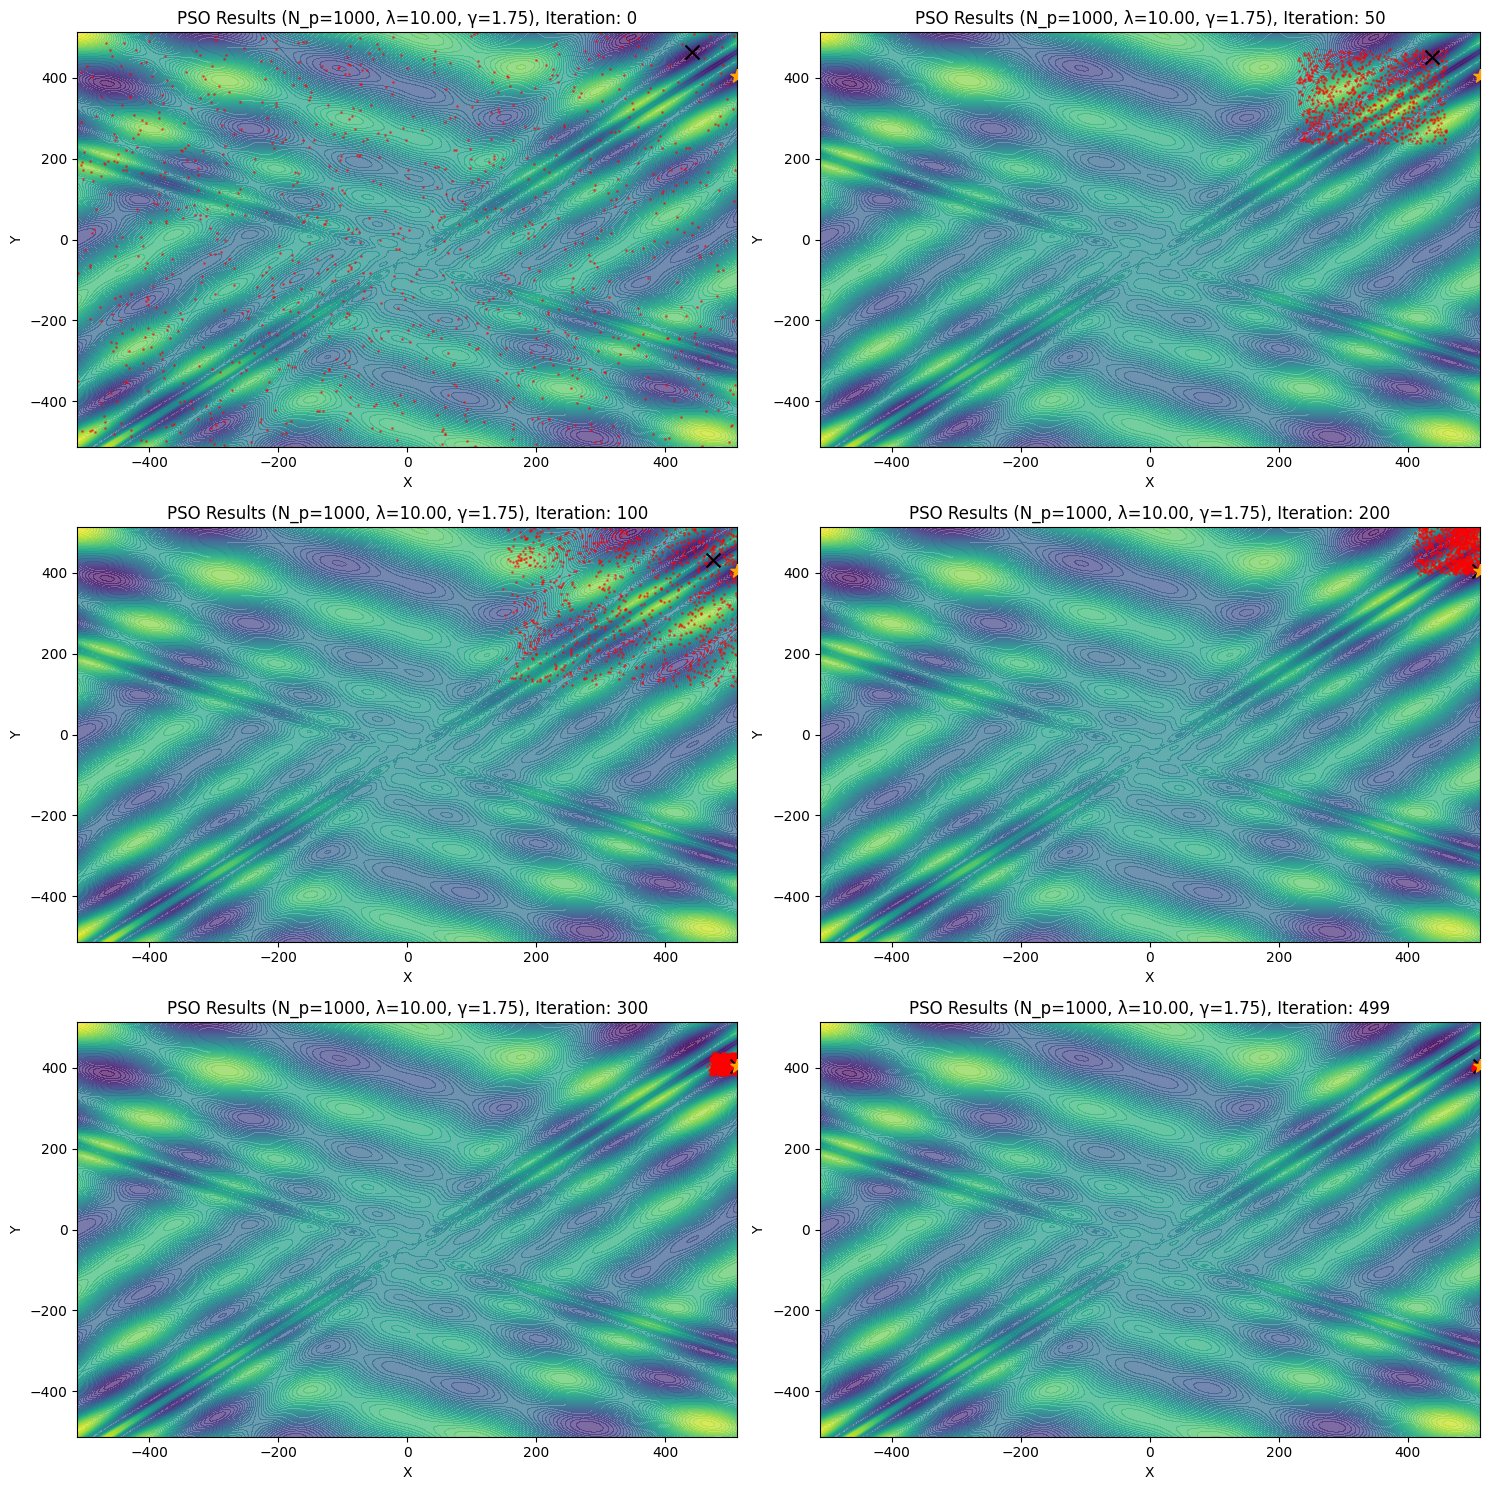

512 404.2319 -959.6401878247957
Reflections:  9554


In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Grid search for optimal parameters
Lambda = 10
gamma = 1.75
N_particles = 1000
radius = 512
objective_function = egg_holder

particle_positions_X = np.random.uniform(-512, 512, (N_particles, 2))
particle_velocities_V = np.random.uniform(-1, 1, (N_particles, 2))
time = 0

# Create a grid for the contour plot
x = np.linspace(-512, 512, 1000)
y = np.linspace(-512, 512, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)

best_min = np.min(objective_function(particle_positions_X))
print("N_particles: ", N_particles, "Lambda: ", Lambda, "gamma: ", gamma, "objective: ", np.min(objective_function(particle_positions_X)))
min_x, min_y = [512, 404.2319]

reflection_counter = [0]
plot_list = [0,50,100,200,300, 499]

# Create a figure with subplots (3 rows and 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()  # Flatten the axes array for easier indexing

while time < T:
    iteration = int(time / h)
    if iteration in plot_list:
        index = plot_list.index(iteration)  # Get the index of the current iteration in plot_list
        ax = axes[index]  # Select the corresponding subplot
        
        # Plotting on the selected subplot
        ax.contourf(X, Y, Z, levels=50, cmap='viridis', alpha=0.7)
        ax.set_xlim(-512, 512)
        ax.set_ylim(-512, 512)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'PSO Results (N_p={N_particles}, λ={Lambda:.2f}, γ={gamma:.2f}), Iteration: {iteration}')
        
        # Plot particle positions
        ax.plot(particle_positions_X[:, 0], particle_positions_X[:, 1], 'ro', markersize=1, alpha=0.5)
        
        # Highlight best particle and global minimum
        best_min_x, best_min_y = best_particle(particle_positions_X, objective_function)
        ax.scatter(best_min_x, best_min_y, color='black', s=100, zorder=5, marker='x')
        ax.scatter(min_x, min_y, color='orange', s=100, zorder=5, marker='*')

    sigma = sigma_function(time)
    particle_positions_X, particle_velocities_V = PSO(
        particle_positions_X,
        particle_velocities_V,
        objective_function,
        Lambda,
        gamma,
        sigma,
        radius,
        reflection_counter,
        square=True,
    )
    time += h

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

min_index = np.argmin(objective_function(particle_positions_X))
print(min_x, min_y, objective_function(particle_positions_X)[min_index])
print("Reflections: ", reflection_counter[0])


In [12]:
def success_function(X, global_minima, objective_function):
    best_part= best_particle(X, objective_function)
    if global_minima.ndim == 1:
        distances = np.linalg.norm(best_part - global_minima)
    else:
        distances = np.linalg.norm(best_part - global_minima,axis=1)
    return np.any(distances < 0.2)

In [ ]:
#Grid search for optimal parameters
alpha = 0.5
Lambda = 10
gamma = 1
N_particles = 1000
square_length = 512

objective_function = egg_holder
# Define the global minima
global_minima_eggholder = np.array([512, 404.2319])
success = 0
particle_positions_X = np.random.uniform(-512,512,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
time = 0
# Create a grid for the contour plot
x = np.linspace(-square_length, square_length, 1000)
y = np.linspace(-square_length, square_length, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)



lambda_values = [0.1, 1, 5, 10, 15]
gamma_values = [0.1, 1, 5, 10, 15]
for Lambda in lambda_values:
    for gamma in gamma_values:
        reflection_counter = [0]
        time = 0
        particle_positions_X = np.random.uniform(-square_length,square_length,(N_particles,2))
        particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
        while time<T:
            sigma = sigma_function(time)
            particle_positions_X, particle_velocities_V = PSO(particle_positions_X, particle_velocities_V,objective_function,Lambda,gamma,sigma,square_length,reflection_counter,square = True)
            #print("alpha: ",alpha,"Lambda: ",Lambda,"gamma: ",gamma,"objective: ",np.min(objective_function(particle_positions_X)))
            time += h
        plt.figure(figsize=(10, 8))
        if success_function(particle_positions_X, global_minima_eggholder, alpha, objective_function):
            plt.title(f'PSO Results (α={alpha}, λ={Lambda:.2f}, γ={gamma:.2f}) Successful run')
        else:
            plt.title(f'PSO Results (α={alpha}, λ={Lambda:.2f}, γ={gamma:.2f}) failed run')
        # Plot masked contour
        plt.contourf(X, Y, Z,levels=50, cmap='viridis', alpha=0.7, shading='auto')
        plt.colorbar(label='Eggholder Function Value')

        plt.xlim(-square_length,square_length)
        plt.ylim(-square_length, square_length)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.plot(particle_positions_X[:,0], particle_positions_X[:,1], 'ro', markersize=1.5, alpha=0.5)
        min_index = np.argmin(objective_function(particle_positions_X))
        min_x, min_y = particle_positions_X[min_index]
        best_min_x, best_min_y = best_particle(particle_positions_X,objective_function)
        plt.plot(best_min_x, best_min_y, color='black',marker='^', markersize=5)
        plt.scatter(global_minima_eggholder[0], global_minima_eggholder[1], color='yellow', s=100, zorder=5, marker='*')
        best_min = np.min(objective_function(particle_positions_X))
        print("alpha: ",alpha,"Lambda: ",Lambda,"gamma: ",gamma,"objective: ",np.min(objective_function(particle_positions_X)))
        print(min_x, min_y, objective_function(particle_positions_X)[min_index])
        print("Weighted average: ",weighted_average(particle_positions_X,alpha,objective_function))
        plt.show()

TypeError: PSO() got multiple values for argument 'square'

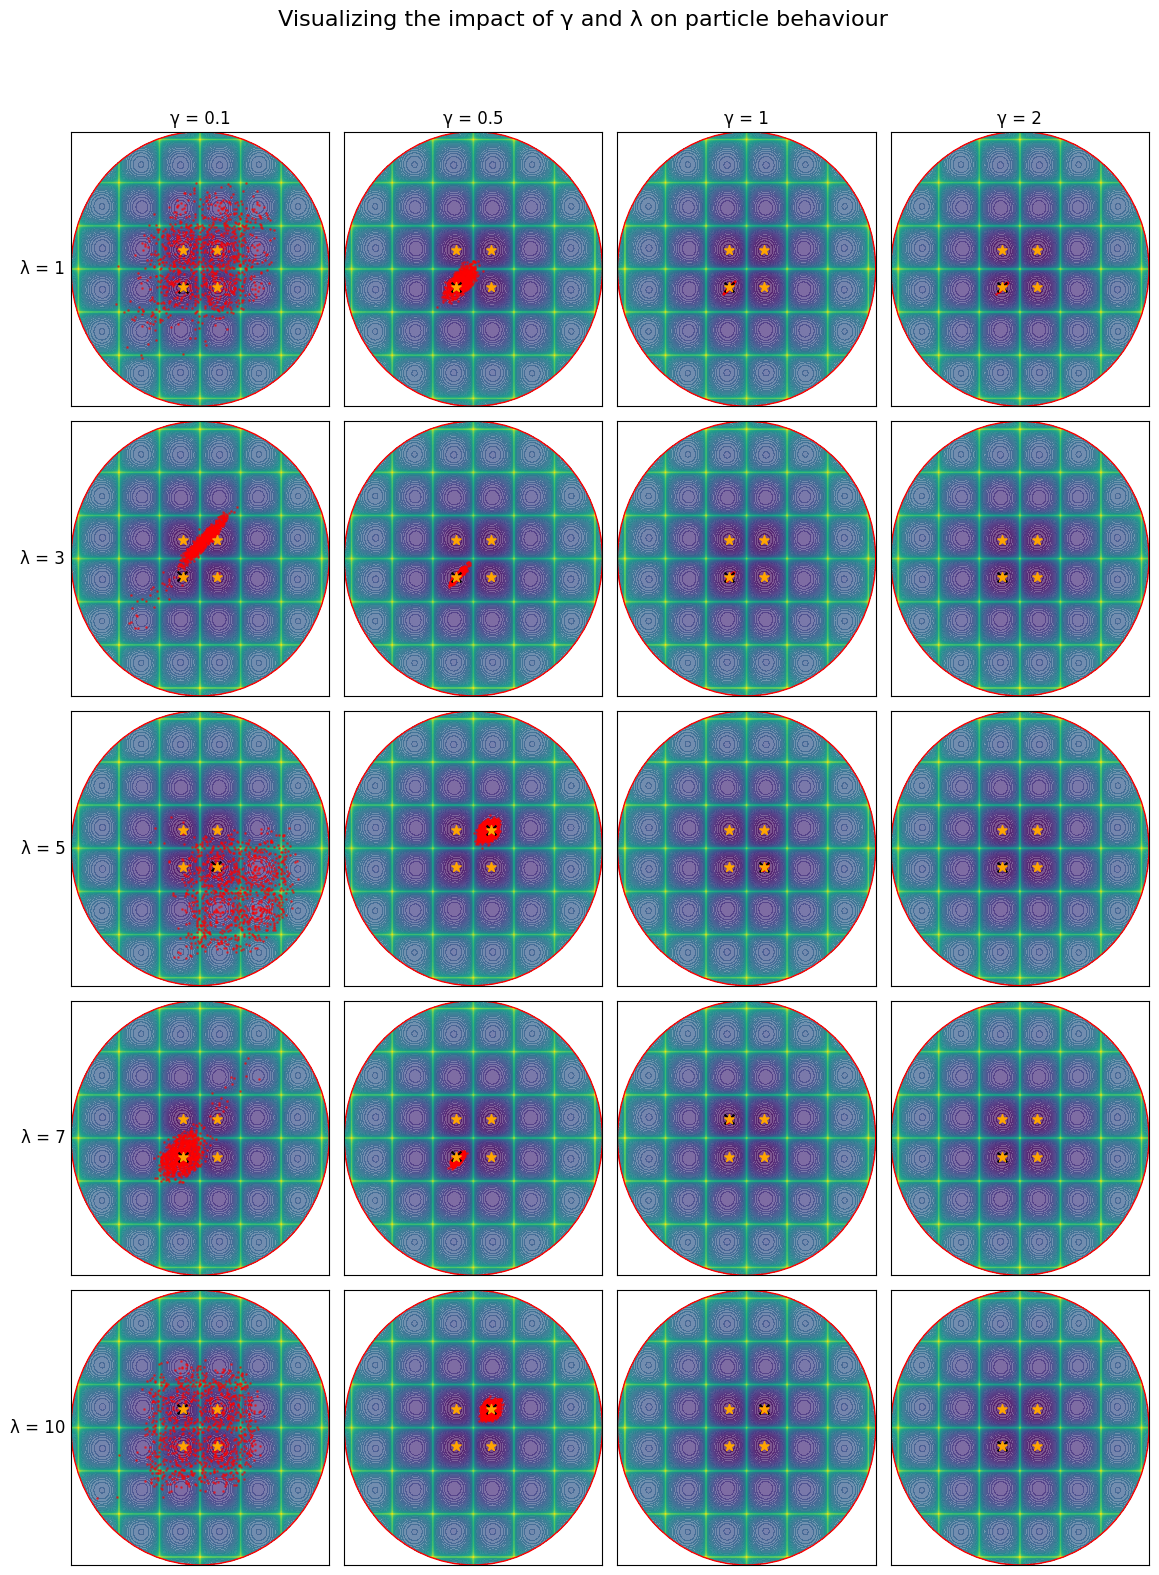

In [27]:
N_particles = 1000
radius = 10

objective_function = cross_in_tray
# Define the global minima
global_minima_cross_in_tray = np.array([
    [1.34941, -1.34941],
    [1.34941, 1.34941],
    [-1.34941, 1.34941],
    [-1.34941, -1.34941]
])
success = 0
# Create a grid for the contour plot
x = np.linspace(-radius, radius, 1000)
y = np.linspace(-radius, radius, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)

min_x = global_minima_cross_in_tray[:, 0]
min_y = global_minima_cross_in_tray[:, 1]

# Create circular mask
mask = X**2 + Y**2 <= radius**2
Z_masked = np.ma.masked_where(~mask, Z)


# Define gamma and lambda values
gamma_values = [0.1, 0.5, 1, 2]
lambda_values = [1, 3, 5, 7, 10]

# Create figure and subfigures
fig, axs = plt.subplots(len(lambda_values), len(gamma_values), figsize=(11.69, 16.53))  # A4 size in inches
fig.suptitle(' Visualizing the impact of γ and λ on particle behaviour', fontsize=16)

# Add column labels (gamma values)
for ax, gamma in zip(axs[0], gamma_values):
    ax.set_title(f'γ = {gamma}', fontsize=12)

# Add row labels (lambda values)
for ax, lambda_ in zip(axs[:, 0], lambda_values):
    ax.set_ylabel(f'λ = {lambda_}', rotation=0, ha='right', va='center',fontsize = 12)

for i, Lambda in enumerate(lambda_values):
    for j, gamma in enumerate(gamma_values):
        reflection_counter = [0]
        time = 0
        particle_positions_X = np.random.uniform(-7, 7, (N_particles, 2))
        particle_velocities_V = np.random.uniform(-1, 1, (N_particles, 2))
        
        while time < T:
            sigma = sigma_function(time)
            particle_positions_X, particle_velocities_V = PSO(particle_positions_X, particle_velocities_V, objective_function, Lambda, gamma, sigma, radius, reflection_counter, square=False)
            time += h
        
        ax = axs[i, j]
        
        # Plot masked contour
        im = ax.contourf(X, Y, Z_masked, levels=50, cmap='viridis', alpha=0.7)
        
        # Add circle boundary
        circle = plt.Circle((0, 0), radius, fill=False, color='red', linewidth=1)
        ax.add_artist(circle)
        
        ax.set_xlim(-radius, radius)
        ax.set_ylim(-radius, radius)
        
        ax.plot(particle_positions_X[:, 0], particle_positions_X[:, 1], 'ro', markersize=1, alpha=0.5)
        best_min_x, best_min_y = best_particle(particle_positions_X, objective_function)
        ax.scatter(best_min_x, best_min_y, color='black', s=50, zorder=5, marker='x')
        ax.scatter(min_x, min_y, color='orange', s=50, zorder=5, marker='*')
        
        # Remove tick labels for a cleaner look
        ax.set_xticks([])
        ax.set_yticks([])

# Adjust layout and add colorbar
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


In [ ]:
#Grid search for optimal parameters
Lambda = 10
gamma = 1
N_particles = 1000
radius = 10

objective_function = cross_in_tray
# Define the global minima
global_minima_cross_in_tray = np.array([
    [1.34941, -1.34941],
    [1.34941, 1.34941],
    [-1.34941, 1.34941],
    [-1.34941, -1.34941]
])
success = 0
particle_positions_X = np.random.uniform(-7,7,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
time = 0
# Create a grid for the contour plot
x = np.linspace(-radius, radius, 1000)
y = np.linspace(-radius, radius, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)

min_x = global_minima_cross_in_tray[:, 0]
min_y = global_minima_cross_in_tray[:, 1]

# Create circular mask
mask = X**2 + Y**2 <= radius**2
Z_masked = np.ma.masked_where(~mask, Z)

gamma_values = [0.1, 0.5, 1, 2]
lambda_values = [1, 3, 5, 7, 10]

# Create figure and subfigures
fig, axs = plt.subplots(len(lambda_values), len(gamma_values), figsize=(11.69, 16.53))  # A4 size in inches
fig.suptitle('PSO Results for Different γ and λ Values', fontsize=16)


# Add column labels (gamma values)
for ax, gamma in zip(axs[0], gamma_values):
    ax.set_title(f'γ = {gamma}')

# Add row labels (lambda values)
for ax, lambda_ in zip(axs[:, 0], lambda_values):
    ax.set_ylabel(f'λ = {lambda_}', rotation=0, ha='right', va='center')

for Lambda_ in np.linspace(1,10,5):
    for gamma_ in np.linspace(0.1,1,10):
        reflection_counter = [0]
        Lambda = Lambda_
        gamma = gamma_
        time = 0
        particle_positions_X = np.random.uniform(-7,7,(N_particles,2))
        particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
        while time<T:
            sigma = sigma_function(time)
            particle_positions_X, particle_velocities_V = PSO(particle_positions_X, particle_velocities_V,objective_function,Lambda,gamma,sigma,radius,reflection_counter,square = False)
            time += h
        plt.figure(figsize=(10, 8))
        if success_function(particle_positions_X, global_minima_cross_in_tray, objective_function):
            plt.title(f'PSO Results (N_p={N_particles}, λ={Lambda:.2f}, γ={gamma:.2f}) Successful run')
        else:
            plt.title(f'PSO Results (N_p={N_particles}, λ={Lambda:.2f}, γ={gamma:.2f}) failed run')
        # Plot masked contour
        plt.contourf(X, Y, Z_masked,levels=50, cmap='viridis', alpha=0.7, shading='auto')
        plt.colorbar(label='Cross-In-Tray Function Value')

        # Add circle boundary
        circle = plt.Circle((0, 0), radius, fill=False, color='red', linewidth=2)
        plt.gca().add_artist(circle)

        plt.xlim(-radius, radius)
        plt.ylim(-radius, radius)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.plot(particle_positions_X[:,0], particle_positions_X[:,1], 'ro', markersize=1, alpha=0.5)
        best_min_x, best_min_y = best_particle(particle_positions_X,objective_function)
        plt.scatter(best_min_x, best_min_y, color='black', s=100, zorder=5, marker='x')
        plt.scatter(min_x, min_y, color='orange', s=100, zorder=5, marker='*')
        

In [18]:
#Grid search for optimal parameters
N_particles = 1000
square_length = 512
N_iter = 1000

objective_function = egg_holder
# Define the global minima
global_minima_eggholder = np.array([512, 404.2319])
success = 0
particle_positions_X = np.random.uniform(-512,512,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
time = 0
# Create a grid for the contour plot
x = np.linspace(-square_length, square_length, 1000)
y = np.linspace(-square_length, square_length, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)



lambda_values = [5, 8, 10, 12, 15]
gamma_values = [0.8, 1, 1.25, 1.5, 1.75]
results = np.zeros((len(lambda_values), len(gamma_values)))
for i, Lambda in enumerate(lambda_values):
    for j, gamma in enumerate(gamma_values):
        success = 0
        for _ in range(N_iter):
            time = 0
            reflection_count = [0]
            particle_positions_X = np.random.uniform(-square_length, square_length, (N_particles, 2))
            particle_velocities_V = np.random.uniform(-1, 1, (N_particles, 2))
            
            while time < T:
                sigma = sigma_function(time)
                particle_positions_X, particle_velocities_V = PSO(particle_positions_X, particle_velocities_V, objective_function, Lambda, gamma, sigma, square_length, reflection_count)
                time += h
            
            if success_function(particle_positions_X, global_minima_eggholder, objective_function):
                success += 1
        
        success_rate = success / N_iter * 100
        results[i, j] = success_rate
        
        print(f"Lambda: {Lambda}, Gamma: {gamma}, Success rate: {success_rate:.2f}%, Reflections: {reflection_count[0]}")



Lambda: 5, Gamma: 0.8, Success rate: 12.40%, Reflections: 7360
Lambda: 5, Gamma: 1, Success rate: 33.30%, Reflections: 3553
Lambda: 5, Gamma: 1.25, Success rate: 61.60%, Reflections: 6803
Lambda: 5, Gamma: 1.5, Success rate: 26.10%, Reflections: 2281
Lambda: 5, Gamma: 1.75, Success rate: 11.30%, Reflections: 564
Lambda: 8, Gamma: 0.8, Success rate: 6.50%, Reflections: 9339
Lambda: 8, Gamma: 1, Success rate: 20.10%, Reflections: 8670
Lambda: 8, Gamma: 1.25, Success rate: 44.70%, Reflections: 3779
Lambda: 8, Gamma: 1.5, Success rate: 70.30%, Reflections: 8654
Lambda: 8, Gamma: 1.75, Success rate: 38.50%, Reflections: 8473
Lambda: 10, Gamma: 0.8, Success rate: 8.10%, Reflections: 9688
Lambda: 10, Gamma: 1, Success rate: 17.10%, Reflections: 3684
Lambda: 10, Gamma: 1.25, Success rate: 52.50%, Reflections: 9909
Lambda: 10, Gamma: 1.5, Success rate: 50.30%, Reflections: 3888
Lambda: 10, Gamma: 1.75, Success rate: 74.00%, Reflections: 1937
Lambda: 12, Gamma: 0.8, Success rate: 8.70%, Reflecti

'for Lambda in lambda_values:\n    for gamma in gamma_values:\n        \n        success = 0\n        for i in range(N_iter):\n            time = 0\n            reflection_count = [0]\n            particle_positions_X = np.random.uniform(-square_length,square_length,(N_particles,2))\n            particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))\n            while time<T:\n                sigma = sigma_function(time)\n                particle_positions_X, particle_velocities_V = PSO(particle_positions_X, particle_velocities_V,alpha,objective_function,Lambda,gamma,sigma,square_length,reflection_count)\n                #print("alpha: ",alpha,"Lambda: ",Lambda,"gamma: ",gamma,"objective: ",np.min(objective_function(particle_positions_X)))\n                time += h\n            if success_function(particle_positions_X, global_minima_eggholder, alpha, objective_function):\n                success+=1\n        print("Lambda: ",Lambda," " )\n        print("Gamma: ",gamma," " )\n 

In [ ]:
results_to_table(results, lambda_values, gamma_values)

\begin{table}[]
\begin{tabular}{l|lllll}
\backslashbox{$\lambda$}{$\gamma$} & 0.8 & 1 & 1.25 & 1.5 & 1.75 \\ \hline
$\lambda = 5$ & 12.4\% & 33.3\% & 61.6\% & 26.1\% & 11.3\% \\
$\lambda = 8$ & 6.5\% & 20.1\% & 44.7\% & 70.3\% & 38.5\% \\
$\lambda = 10$ & 8.1\% & 17.1\% & 52.5\% & 50.3\% & 74.0\% \\
$\lambda = 12$ & 8.7\% & 17.4\% & 34.2\% & 55.6\% & 60.1\% \\
$\lambda = 15$ & 10.1\% & 20.6\% & 26.6\% & 54.3\% & 43.6\% \\
\end{tabular}
\end{table}


In [22]:
#Grid search for optimal parameters adding gamma = 2.0
N_particles = 1000
square_length = 512
N_iter = 1000

objective_function = egg_holder
# Define the global minima
global_minima_eggholder = np.array([512, 404.2319])
success = 0
particle_positions_X = np.random.uniform(-512,512,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
time = 0
# Create a grid for the contour plot
x = np.linspace(-square_length, square_length, 1000)
y = np.linspace(-square_length, square_length, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)



lambda_values = [5, 8, 10, 12, 15]
gamma_values = [2.0, 2.25]
results2 = np.zeros((len(lambda_values), len(gamma_values)))
for i, Lambda in enumerate(lambda_values):
    for j, gamma in enumerate(gamma_values):
        success = 0
        for _ in range(N_iter):
            time = 0
            reflection_count = [0]
            particle_positions_X = np.random.uniform(-square_length, square_length, (N_particles, 2))
            particle_velocities_V = np.random.uniform(-1, 1, (N_particles, 2))
            
            while time < T:
                sigma = sigma_function(time)
                particle_positions_X, particle_velocities_V = PSO(particle_positions_X, particle_velocities_V, objective_function, Lambda, gamma, sigma, square_length, reflection_count)
                time += h
            
            if success_function(particle_positions_X, global_minima_eggholder, objective_function):
                success += 1
        
        success_rate = success / N_iter * 100
        results2[i, j] = success_rate
        
        print(f"Lambda: {Lambda}, Gamma: {gamma}, Success rate: {success_rate:.2f}%, Reflections: {reflection_count[0]}")

results_to_table(results2, lambda_values, gamma_values)

Lambda: 5, Gamma: 2.0, Success rate: 14.10%, Reflections: 287
Lambda: 5, Gamma: 2.25, Success rate: 15.40%, Reflections: 900
Lambda: 8, Gamma: 2.0, Success rate: 20.40%, Reflections: 1963
Lambda: 8, Gamma: 2.25, Success rate: 13.20%, Reflections: 1713
Lambda: 10, Gamma: 2.0, Success rate: 33.20%, Reflections: 8974
Lambda: 10, Gamma: 2.25, Success rate: 17.80%, Reflections: 8514
Lambda: 12, Gamma: 2.0, Success rate: 70.50%, Reflections: 10011
Lambda: 12, Gamma: 2.25, Success rate: 30.90%, Reflections: 10369
Lambda: 15, Gamma: 2.0, Success rate: 62.80%, Reflections: 2943
Lambda: 15, Gamma: 2.25, Success rate: 71.80%, Reflections: 10953
\begin{table}[]
\begin{tabular}{l|ll}
\backslashbox{$\lambda$}{$\gamma$} & 2.0 & 2.25 \\ \hline
$\lambda = 5$ & 14.1\% & 15.4\% \\
$\lambda = 8$ & 20.4\% & 13.2\% \\
$\lambda = 10$ & 33.2\% & 17.8\% \\
$\lambda = 12$ & 70.5\% & 30.9\% \\
$\lambda = 15$ & 62.8\% & 71.8\% \\
\end{tabular}
\end{table}


In [17]:
def sigma_function_temp(time,t_0,magnitude):
    if time < t_0:
        return magnitude
    else:
        return 10**(-5)

In [33]:
#Grid search for optimal parameters, checking dependence on number of particles.

square_length = 512
N_iter = 1000

objective_function = egg_holder
# Define the global minima
global_minima_eggholder = np.array([512, 404.2319])

particle_positions_X = np.random.uniform(-512,512,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
time = 0
# Create a grid for the contour plot
x = np.linspace(-square_length, square_length, 1000)
y = np.linspace(-square_length, square_length, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)


Lambda = 10
gamma = 1.75
N_particles = 1000
t_0 = [7]
sigma_magnitude = [100]
results = np.zeros((len(sigma_magnitude), len(t_0)))
for i, magnitude in enumerate(sigma_magnitude):
    for j, stoptimes in enumerate(t_0):
        success = 0
        for _ in range(N_iter):
            time = 0
            reflection_count = [0]
            particle_positions_X = np.random.uniform(-square_length, square_length, (N_particles, 2))
            particle_velocities_V = np.random.uniform(-1, 1, (N_particles, 2))

            while time < T:
                sigma = sigma_function_temp(time,stoptimes,magnitude)
                particle_positions_X, particle_velocities_V = PSO(particle_positions_X, particle_velocities_V, objective_function, Lambda, gamma, sigma, square_length, reflection_count)
                time += h

            if success_function(particle_positions_X, global_minima_eggholder, objective_function):
                success += 1

        success_rate = success / N_iter * 100
        results[i,j] = success_rate

        print(f"t_0: {stoptimes}, magnitude: {magnitude}, Success rate: {success_rate:.2f}%, Reflections: {reflection_count[0]}")

results_to_table(results, sigma_magnitude, t_0)


t_0: 7, magnitude: 100, Success rate: 62.70%, Reflections: 9756
\begin{table}[]
\begin{tabular}{l|l}
\backslashbox{$\lambda$}{$\gamma$} & 7 \\ \hline
$\lambda = 100$ & 62.7\% \\
\end{tabular}
\end{table}


In [31]:
h

0.01

In [ ]:
#Grid search for optimal parameters
radius = 10

objective_function = cross_in_tray
# Define the global minima
global_minima_cross_in_tray = np.array([
    [1.34941, -1.34941],
    [1.34941, 1.34941],
    [-1.34941, 1.34941],
    [-1.34941, -1.34941]
])
N_iter = 1000
Lambda = 10
gamma = 1.75
N_list = [3, 5, 10, 20, 50]


#results = np.zeros(len(N_particles))
for i, N_particles in enumerate(N_list):
    success = 0
    for _ in range(N_iter):
        time = 0
        reflection_count = [0]
        particle_positions_X = np.random.uniform(-7, 7, (N_particles, 2))
        particle_velocities_V = np.random.uniform(-1, 1, (N_particles, 2))

        while time < T:
            sigma = sigma_function(time)
            particle_positions_X, particle_velocities_V = PSO(particle_positions_X, particle_velocities_V, objective_function, Lambda, gamma, sigma, radius, reflection_count, square = False)
            time += h

        if success_function(particle_positions_X, global_minima_cross_in_tray, objective_function):
            success += 1

    success_rate = success / N_iter * 100
    #results[i] = success_rate

    print(f"N_particles: {N_particles}, Success rate: {success_rate:.2f}%, Reflections: {reflection_count[0]}")


N_particles: 3, Success rate: 49.40%, Reflections: 0
N_particles: 5, Success rate: 84.60%, Reflections: 0
N_particles: 10, Success rate: 99.00%, Reflections: 0
N_particles: 20, Success rate: 100.00%, Reflections: 0
N_particles: 50, Success rate: 100.00%, Reflections: 0


In [15]:
#Grid search for optimal parameters, checking dependence on number of particles.

square_length = 512
N_iter = 1000

objective_function = egg_holder
# Define the global minima
global_minima_eggholder = np.array([512, 404.2319])

particle_positions_X = np.random.uniform(-512,512,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
time = 0
# Create a grid for the contour plot
x = np.linspace(-square_length, square_length, 1000)
y = np.linspace(-square_length, square_length, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)


Lambda = 10
gamma = 1.75
N_particles = 1000
h = 0.001 # New time step, smaller than before
Time_list = [10,15,20,25] # New time limit

for i, T in enumerate(Time_list):
    success = 0
    for _ in range(N_iter):
        time = 0
        reflection_count = [0]
        particle_positions_X = np.random.uniform(-square_length, square_length, (N_particles, 2))
        particle_velocities_V = np.random.uniform(-1, 1, (N_particles, 2))

        while time < T:
            sigma = sigma_function(time)
            particle_positions_X, particle_velocities_V = PSO(particle_positions_X, particle_velocities_V, objective_function, Lambda, gamma, sigma, square_length, reflection_count)
            time += h

        if success_function(particle_positions_X, global_minima_eggholder, objective_function):
            success += 1

    success_rate = success / N_iter * 100
    #results[i,j] = success_rate

    print(f"T: {T}, step-size: {h}, Success rate: {success_rate:.2f}%, Reflections: {reflection_count[0]}")

#results_to_table(results, sigma_magnitude, t_0)


T: 10, step-size: 0.001, Success rate: 75.70%, Reflections: 9492
T: 15, step-size: 0.001, Success rate: 77.70%, Reflections: 14177
T: 20, step-size: 0.001, Success rate: 76.30%, Reflections: 19079
T: 25, step-size: 0.001, Success rate: 76.90%, Reflections: 23983


In [ ]:
#Grid search for optimal parameters, checking dependence on number of particles.
square_length = 512
N_iter = 1000

objective_function = egg_holder
# Define the global minima
global_minima_eggholder = np.array([512, 404.2319])

particle_positions_X = np.random.uniform(-512,512,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
time = 0
# Create a grid for the contour plot
x = np.linspace(-square_length, square_length, 1000)
y = np.linspace(-square_length, square_length, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)


Lambda = 10
gamma = 1.75
N_particles = 1000
h = 0.001 # New time step, smaller than before
Time_list = [10,15,20,25] # New time limit


for i, T in enumerate(Time_list):
    success = 0
    for _ in range(N_iter):
        time = 0
        reflection_count = [0]
        particle_positions_X = np.random.uniform(-square_length, square_length, (N_particles, 2))
        particle_velocities_V = np.random.uniform(-1, 1, (N_particles, 2))

        while time < T:
            sigma = sigma_function_temp(time,t_0=0.7*T,magnitude=15)
            particle_positions_X, particle_velocities_V = PSO(particle_positions_X, particle_velocities_V, objective_function, Lambda, gamma, sigma, square_length, reflection_count)
            time += h

        if success_function(particle_positions_X, global_minima_eggholder, objective_function):
            success += 1

    success_rate = success / N_iter * 100
    #results[i,j] = success_rate

    print(f"T: {T}, exploration time: {0.7*T}, Success rate: {success_rate:.2f}%, Reflections: {reflection_count[0]}")

#results_to_table(results, sigma_magnitude, t_0)


T: 10, exploration time: 7.0, Success rate: 72.00%, Reflections: 10026
T: 15, exploration time: 10.5, Success rate: 75.80%, Reflections: 14869
T: 20, exploration time: 14.0, Success rate: 76.90%, Reflections: 19279
T: 25, exploration time: 17.5, Success rate: 75.10%, Reflections: 24362


-1.3510741433767806 -1.3690331926335535 -2.0625671989116303
Weighted average:  [-1.36461604 -1.30760355]


<Figure size 1000x800 with 0 Axes>

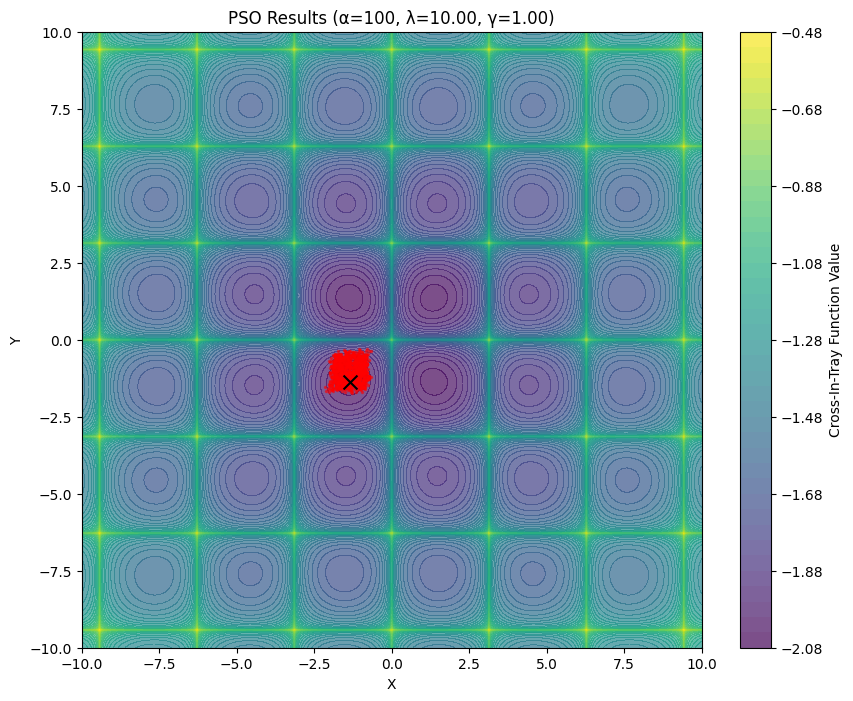

In [ ]:
#Grid search for optimal parameters
alpha = 100
Lambda = 10
gamma = 1

radius = 10

objective_function = cross_in_tray
# Define the global minima
global_minima_cross_in_tray = np.array([
    [1.34941, -1.34941],
    [1.34941, 1.34941],
    [-1.34941, 1.34941],
    [-1.34941, -1.34941]
])
success = 0
particle_positions_X = np.random.uniform(-7,7,(N_particles,2))
particle_velocities_V = np.random.uniform(-1,1,(N_particles,2))
time = 0
# Create a grid for the contour plot
x = np.linspace(-10, 10, 1000)
y = np.linspace(-10, 10, 1000)
X, Y = np.meshgrid(x, y)
Z = objective_function(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)
plt.figure(figsize=(10, 8))
# Plotting
#plt.plot(particle_positions_X[:,0], particle_positions_X[:,1], 'ro', markersize=1.5, alpha=0.5)

while time<T:
    sigma = sigma_function(time)
    particle_positions_X, particle_velocities_V = PSO(particle_positions_X, particle_velocities_V,alpha,objective_function,Lambda,gamma,sigma,radius)
    time += h
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Z, levels=50, cmap='viridis', alpha=0.7)
plt.colorbar(label='Cross-In-Tray Function Value')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'PSO Results (α={alpha}, λ={Lambda:.2f}, γ={gamma:.2f})')
plt.plot(particle_positions_X[:,0], particle_positions_X[:,1], 'ro', markersize=1.5, alpha=0.5)
min_index = np.argmin(objective_function(particle_positions_X))
min_x, min_y = particle_positions_X[min_index]
plt.scatter(min_x, min_y, color='black', s=100, zorder=5, marker='x')
print(min_x, min_y, objective_function(particle_positions_X)[min_index])
print("Weighted average: ",weighted_average(particle_positions_X,alpha,objective_function))
plt.show()



In [41]:
print(success)

201
